# 第3章: 正規表現
Wikipediaの記事を以下のフォーマットで書き出したファイル[jawiki-country.json.gz](/data/jawiki-country.json.gz)がある。

* 1行に1記事の情報がJSON形式で格納される
* 各行には記事名が"title"キーに、記事本文が"text"キーの辞書オブジェクトに格納され、そのオブジェクトがJSON形式で書き出される
* ファイル全体はgzipで圧縮される

以下の処理を行うプログラムを作成せよ。

## 20. JSONデータの読み込み
Wikipedia記事のJSONファイルを読み込み、「イギリス」に関する記事本文を表示せよ。問題21-29では、ここで抽出した記事本文に対して実行せよ。

In [2]:
import json
text_list = []
with open('../data/jawiki-country.json') as f:
    lines = f.readlines()
    for line in lines:
        text_list.append(json.loads(line))

In [3]:
for i in range(len(text_list)):
    if text_list[i]['title'] == 'イギリス':
        # UK_text = str(text_list[i])
        UK_json = text_list[i]
        break

In [4]:
UK_text = str(UK_json['text'])
UK_text[:200]

'{{redirect|UK}}\n{{redirect|英国|春秋時代の諸侯国|英 (春秋)}}\n{{Otheruses|ヨーロッパの国|長崎県・熊本県の郷土料理|いぎりす}}\n{{基礎情報 国\n|略名  =イギリス\n|日本語国名 = グレートブリテン及び北アイルランド連合王国\n|公式国名 = {{lang|en|United Kingdom of Great Britain and Norther'

## 21. カテゴリ名を含む行を抽出
記事中でカテゴリ名を宣言している行を抽出せよ。

In [5]:
import re
pattern = re.compile(r'\[\[Category:.*?\]\]')
result = pattern.findall(UK_text)
result

['[[Category:イギリス|*]]',
 '[[Category:イギリス連邦加盟国]]',
 '[[Category:英連邦王国|*]]',
 '[[Category:G8加盟国]]',
 '[[Category:欧州連合加盟国|元]]',
 '[[Category:海洋国家]]',
 '[[Category:現存する君主国]]',
 '[[Category:島国]]',
 '[[Category:1801年に成立した国家・領域]]']

## 22. カテゴリ名の抽出
記事のカテゴリ名を（行単位ではなく名前で）抽出せよ。

In [6]:
for item in result:
    category_str = item.replace('[[Category:', '').replace(']]', '').replace('|*', '')
    print(category_str)

イギリス
イギリス連邦加盟国
英連邦王国
G8加盟国
欧州連合加盟国|元
海洋国家
現存する君主国
島国
1801年に成立した国家・領域


## 23. セクション構造
記事中に含まれるセクション名とそのレベル（例えば"== セクション名 =="なら1）を表示せよ。

In [7]:
import re
pattern = re.compile(r'==.*==')
result = pattern.findall(UK_text)
result
for item in result:
    level = int(len(re.findall(r'=', item))/2-1)
    print(f'{item} -> {level}')

==国名== -> 1
==歴史== -> 1
==地理== -> 1
===主要都市=== -> 2
===気候=== -> 2
==政治== -> 1
===元首=== -> 2
===法=== -> 2
===内政=== -> 2
===地方行政区分=== -> 2
===外交・軍事=== -> 2
==経済== -> 1
===鉱業=== -> 2
===農業=== -> 2
===貿易=== -> 2
===不動産=== -> 2
===エネルギー政策=== -> 2
===通貨=== -> 2
===企業=== -> 2
====通信==== -> 3
==交通== -> 1
===道路=== -> 2
===鉄道=== -> 2
===海運=== -> 2
===航空=== -> 2
==科学技術== -> 1
==国民== -> 1
===言語=== -> 2
===宗教=== -> 2
===婚姻=== -> 2
===移住=== -> 2
===教育=== -> 2
===医療=== -> 2
==文化== -> 1
===食文化=== -> 2
===文学=== -> 2
===哲学=== -> 2
===音楽=== -> 2
====ポピュラー音楽==== -> 3
===映画=== -> 2
===コメディ=== -> 2
===国花=== -> 2
===世界遺産=== -> 2
===祝祭日=== -> 2
===スポーツ=== -> 2
====サッカー==== -> 3
====クリケット==== -> 3
====競馬==== -> 3
====モータースポーツ==== -> 3
====野球==== -> 3
==== カーリング ==== -> 3
==== 自転車競技 ==== -> 3
==脚注== -> 1
==関連項目== -> 1
==外部リンク== -> 1


## 24. ファイル参照の抽出
記事から参照されているメディアファイルをすべて抜き出せ。

In [8]:
import re
pattern = re.compile(r'ファイル:(.+?)\|')
result = pattern.findall(UK_text)
print('\n'.join(result))

Royal Coat of Arms of the United Kingdom.svg
Descriptio Prime Tabulae Europae.jpg
Lenepveu, Jeanne d'Arc au siège d'Orléans.jpg
London.bankofengland.arp.jpg
Battle of Waterloo 1815.PNG
Uk topo en.jpg
BenNevis2005.jpg
Population density UK 2011 census.png
2019 Greenwich Peninsula & Canary Wharf.jpg
Birmingham Skyline from Edgbaston Cricket Ground crop.jpg
Leeds CBD at night.jpg
Glasgow and the Clyde from the air (geograph 4665720).jpg
Palace of Westminster, London - Feb 2007.jpg
Scotland Parliament Holyrood.jpg
Donald Trump and Theresa May (33998675310) (cropped).jpg
Soldiers Trooping the Colour, 16th June 2007.jpg
City of London skyline from London City Hall - Oct 2008.jpg
Oil platform in the North SeaPros.jpg
Eurostar at St Pancras Jan 2008.jpg
Heathrow Terminal 5C Iwelumo-1.jpg
Airbus A380-841 G-XLEB British Airways (10424102995).jpg
UKpop.svg
Anglospeak.svg
Royal Aberdeen Children's Hospital.jpg
CHANDOS3.jpg
The Fabs.JPG
Wembley Stadium, illuminated.jpg


## 25. テンプレートの抽出
記事中に含まれる「基礎情報」テンプレートのフィールド名と値を抽出し、辞書オブジェクトとして格納せよ。

In [9]:
import re
pattern = re.compile(r'\|(.+?)\s=\s*(.+)')
result = pattern.findall(UK_text)

In [10]:
fundamental_info = {}
for item in result:
    print(item[0],item[1])
    fundamental_info[item[0]] = item[1]
fundamental_info

略名  イギリス
日本語国名 グレートブリテン及び北アイルランド連合王国
公式国名 {{lang|en|United Kingdom of Great Britain and Northern Ireland}}<ref>英語以外での正式国名:<br />
国旗画像 Flag of the United Kingdom.svg
国章画像 [[ファイル:Royal Coat of Arms of the United Kingdom.svg|85px|イギリスの国章]]
国章リンク （[[イギリスの国章|国章]]）
標語 {{lang|fr|[[Dieu et mon droit]]}}<br />（[[フランス語]]:[[Dieu et mon droit|神と我が権利]]）
国歌 [[女王陛下万歳|{{lang|en|God Save the Queen}}]]{{en icon}}<br />''神よ女王を護り賜え''<br />{{center|[[ファイル:United States Navy Band - God Save the Queen.ogg]]}}
地図画像 Europe-UK.svg
位置画像 United Kingdom (+overseas territories) in the World (+Antarctica claims).svg
公用語 [[英語]]
首都 [[ロンドン]]（事実上）
最大都市 ロンドン
元首等肩書 [[イギリスの君主|女王]]
元首等氏名 [[エリザベス2世]]
首相等肩書 [[イギリスの首相|首相]]
首相等氏名 [[ボリス・ジョンソン]]
他元首等肩書1 [[貴族院 (イギリス)|貴族院議長]]
他元首等氏名1 [[:en:Norman Fowler, Baron Fowler|ノーマン・ファウラー]]
他元首等肩書2 [[庶民院 (イギリス)|庶民院議長]]
他元首等氏名2 {{仮リンク|リンゼイ・ホイル|en|Lindsay Hoyle}}
他元首等肩書3 [[連合王国最高裁判所|最高裁判所長官]]
他元首等氏名3 [[:en:Brenda Hale, Baroness Hale of Richmond|ブレンダ・ヘイル]]
面積順位 76
面積大きさ 1 E11
面積値 244,820
水面積率 1.

{'略名 ': 'イギリス',
 '日本語国名': 'グレートブリテン及び北アイルランド連合王国',
 '公式国名': '{{lang|en|United Kingdom of Great Britain and Northern Ireland}}<ref>英語以外での正式国名:<br />',
 '国旗画像': 'Flag of the United Kingdom.svg',
 '国章画像': '[[ファイル:Royal Coat of Arms of the United Kingdom.svg|85px|イギリスの国章]]',
 '国章リンク': '（[[イギリスの国章|国章]]）',
 '標語': '{{lang|fr|[[Dieu et mon droit]]}}<br />（[[フランス語]]:[[Dieu et mon droit|神と我が権利]]）',
 '国歌': "[[女王陛下万歳|{{lang|en|God Save the Queen}}]]{{en icon}}<br />''神よ女王を護り賜え''<br />{{center|[[ファイル:United States Navy Band - God Save the Queen.ogg]]}}",
 '地図画像': 'Europe-UK.svg',
 '位置画像': 'United Kingdom (+overseas territories) in the World (+Antarctica claims).svg',
 '公用語': '[[英語]]',
 '首都': '[[ロンドン]]（事実上）',
 '最大都市': 'ロンドン',
 '元首等肩書': '[[イギリスの君主|女王]]',
 '元首等氏名': '[[エリザベス2世]]',
 '首相等肩書': '[[イギリスの首相|首相]]',
 '首相等氏名': '[[ボリス・ジョンソン]]',
 '他元首等肩書1': '[[貴族院 (イギリス)|貴族院議長]]',
 '他元首等氏名1': '[[:en:Norman Fowler, Baron Fowler|ノーマン・ファウラー]]',
 '他元首等肩書2': '[[庶民院 (イギリス)|庶民院議長]]',
 '他元首等氏名2': '{{仮リンク|リンゼイ・ホイル|en|Lind

In [11]:
fundamental_info['GDP/人']

'36,727<ref name="imf-statistics-gdp" />'

## 26. 強調マークアップの除去
25の処理時に、テンプレートの値からMediaWikiの強調マークアップ（弱い強調、強調、強い強調のすべて）を除去してテキストに変換せよ（参考: [マークアップ早見表](http://ja.wikipedia.org/wiki/Help:%E6%97%A9%E8%A6%8B%E8%A1%A8)）。

In [12]:
fundamental_info = {}
for item in result:
    # print(item[0],item[1])
    fundamental_info[item[0]] = item[1]
    match_sub = re.sub("\'{2,}(.+?)\'{2,}", "\\1", ''.join(item))
    print(match_sub)

略名 イギリス
日本語国名グレートブリテン及び北アイルランド連合王国
公式国名{{lang|en|United Kingdom of Great Britain and Northern Ireland}}<ref>英語以外での正式国名:<br />
国旗画像Flag of the United Kingdom.svg
国章画像[[ファイル:Royal Coat of Arms of the United Kingdom.svg|85px|イギリスの国章]]
国章リンク（[[イギリスの国章|国章]]）
標語{{lang|fr|[[Dieu et mon droit]]}}<br />（[[フランス語]]:[[Dieu et mon droit|神と我が権利]]）
国歌[[女王陛下万歳|{{lang|en|God Save the Queen}}]]{{en icon}}<br />神よ女王を護り賜え<br />{{center|[[ファイル:United States Navy Band - God Save the Queen.ogg]]}}
地図画像Europe-UK.svg
位置画像United Kingdom (+overseas territories) in the World (+Antarctica claims).svg
公用語[[英語]]
首都[[ロンドン]]（事実上）
最大都市ロンドン
元首等肩書[[イギリスの君主|女王]]
元首等氏名[[エリザベス2世]]
首相等肩書[[イギリスの首相|首相]]
首相等氏名[[ボリス・ジョンソン]]
他元首等肩書1[[貴族院 (イギリス)|貴族院議長]]
他元首等氏名1[[:en:Norman Fowler, Baron Fowler|ノーマン・ファウラー]]
他元首等肩書2[[庶民院 (イギリス)|庶民院議長]]
他元首等氏名2{{仮リンク|リンゼイ・ホイル|en|Lindsay Hoyle}}
他元首等肩書3[[連合王国最高裁判所|最高裁判所長官]]
他元首等氏名3[[:en:Brenda Hale, Baroness Hale of Richmond|ブレンダ・ヘイル]]
面積順位76
面積大きさ1 E11
面積値244,820
水面積率1.3%
人口統計年2018
人口順位22
人口大きさ1 E7
人

## 27. 内部リンクの除去
26の処理に加えて、テンプレートの値からMediaWikiの内部リンクマークアップを除去し、テキストに変換せよ（参考: [マークアップ早見表](http://ja.wikipedia.org/wiki/Help:%E6%97%A9%E8%A6%8B%E8%A1%A8)）。

In [13]:
fundamental_info = {}
for item in result:
    # print(item[0],item[1])
    fundamental_info[item[0]] = item[1]
    match_sub = re.sub(r"\'{2,}(.+?)\'{2,}", "\\1", ''.join(item))
    match_sub = re.sub(r"\[\[(.+?)\]\]", "\\1", match_sub)
    print(match_sub)

略名 イギリス
日本語国名グレートブリテン及び北アイルランド連合王国
公式国名{{lang|en|United Kingdom of Great Britain and Northern Ireland}}<ref>英語以外での正式国名:<br />
国旗画像Flag of the United Kingdom.svg
国章画像ファイル:Royal Coat of Arms of the United Kingdom.svg|85px|イギリスの国章
国章リンク（イギリスの国章|国章）
標語{{lang|fr|Dieu et mon droit}}<br />（フランス語:Dieu et mon droit|神と我が権利）
国歌女王陛下万歳|{{lang|en|God Save the Queen}}{{en icon}}<br />神よ女王を護り賜え<br />{{center|ファイル:United States Navy Band - God Save the Queen.ogg}}
地図画像Europe-UK.svg
位置画像United Kingdom (+overseas territories) in the World (+Antarctica claims).svg
公用語英語
首都ロンドン（事実上）
最大都市ロンドン
元首等肩書イギリスの君主|女王
元首等氏名エリザベス2世
首相等肩書イギリスの首相|首相
首相等氏名ボリス・ジョンソン
他元首等肩書1貴族院 (イギリス)|貴族院議長
他元首等氏名1:en:Norman Fowler, Baron Fowler|ノーマン・ファウラー
他元首等肩書2庶民院 (イギリス)|庶民院議長
他元首等氏名2{{仮リンク|リンゼイ・ホイル|en|Lindsay Hoyle}}
他元首等肩書3連合王国最高裁判所|最高裁判所長官
他元首等氏名3:en:Brenda Hale, Baroness Hale of Richmond|ブレンダ・ヘイル
面積順位76
面積大きさ1 E11
面積値244,820
水面積率1.3%
人口統計年2018
人口順位22
人口大きさ1 E7
人口値6643万5600<ref>{{Cite web|url=https://www.ons.gov.uk/peoplepopulationan

## 28. MediaWikiマークアップの除去
27の処理に加えて、テンプレートの値からMediaWikiマークアップを可能な限り除去し、国の基本情報を整形せよ。

In [14]:
fundamental_info = {}
for item in result:
    # print(item[0],item[1])
    fundamental_info[item[0]] = item[1]
    match_sub = re.sub(r"\'{2,}(.+?)\'{2,}", "\\1", ''.join(item))
    match_sub = re.sub(r"\[\[(.+?)\]\]", "\\1", match_sub) #内部リンクマークアップの削除
    match_sub = re.sub(r"\[(.+?)\]", "\\1", match_sub) #外部リンクマークアップの削除
    match_sub = re.sub(r"\*+(.+?)", "\\1", match_sub) #*箇条書きの削除
    match_sub = re.sub(r"\:+(.+?)", "\\1", match_sub)#定義の箇条書きの削除
    match_sub = re.sub(r"\{\{(.+?)\}\}", "\\1", match_sub) #スタブなどを削除
    print(match_sub)

略名 イギリス
日本語国名グレートブリテン及び北アイルランド連合王国
公式国名lang|en|United Kingdom of Great Britain and Northern Ireland<ref>英語以外での正式国名<br />
国旗画像Flag of the United Kingdom.svg
国章画像ファイルRoyal Coat of Arms of the United Kingdom.svg|85px|イギリスの国章
国章リンク（イギリスの国章|国章）
標語lang|fr|Dieu et mon droit<br />（フランス語Dieu et mon droit|神と我が権利）
国歌女王陛下万歳|lang|en|God Save the Queenen icon<br />神よ女王を護り賜え<br />center|ファイルUnited States Navy Band - God Save the Queen.ogg
地図画像Europe-UK.svg
位置画像United Kingdom (+overseas territories) in the World (+Antarctica claims).svg
公用語英語
首都ロンドン（事実上）
最大都市ロンドン
元首等肩書イギリスの君主|女王
元首等氏名エリザベス2世
首相等肩書イギリスの首相|首相
首相等氏名ボリス・ジョンソン
他元首等肩書1貴族院 (イギリス)|貴族院議長
他元首等氏名1enNorman Fowler, Baron Fowler|ノーマン・ファウラー
他元首等肩書2庶民院 (イギリス)|庶民院議長
他元首等氏名2仮リンク|リンゼイ・ホイル|en|Lindsay Hoyle
他元首等肩書3連合王国最高裁判所|最高裁判所長官
他元首等氏名3enBrenda Hale, Baroness Hale of Richmond|ブレンダ・ヘイル
面積順位76
面積大きさ1 E11
面積値244,820
水面積率1.3%
人口統計年2018
人口順位22
人口大きさ1 E7
人口値6643万5600<ref>Cite web|url=https//www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/p

## 29. 国旗画像のURLを取得する
テンプレートの内容を利用し、国旗画像のURLを取得せよ。（ヒント: [MediaWiki API](http://www.mediawiki.org/wiki/API:Main_page/ja)の[imageinfo](https://www.mediawiki.org/wiki/API:Imageinfo)を呼び出して、ファイル参照をURLに変換すればよい）

In [23]:
import requests
 
S = requests.Session()
URL = "https://en.wikipedia.org/w/api.php"

PARAMS = {
    "action": "query",
    "format": "json",
    "prop": "imageinfo",
    "titles": f"File:{fundamental_info['国旗画像']}",
    "iiprop":"url"
}
 
R = S.get(url=URL, params=PARAMS, verify=False) #ZCCが邪魔するので、False指定が必要

DATA = R.json()
PAGES = DATA["query"]["pages"]
 
for k, v in PAGES.items():
    print(v["imageinfo"][0]["url"])

/Users/ryuichi/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


https://upload.wikimedia.org/wikipedia/en/a/ae/Flag_of_the_United_Kingdom.svg


/Users/ryuichi/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'upload.wikimedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


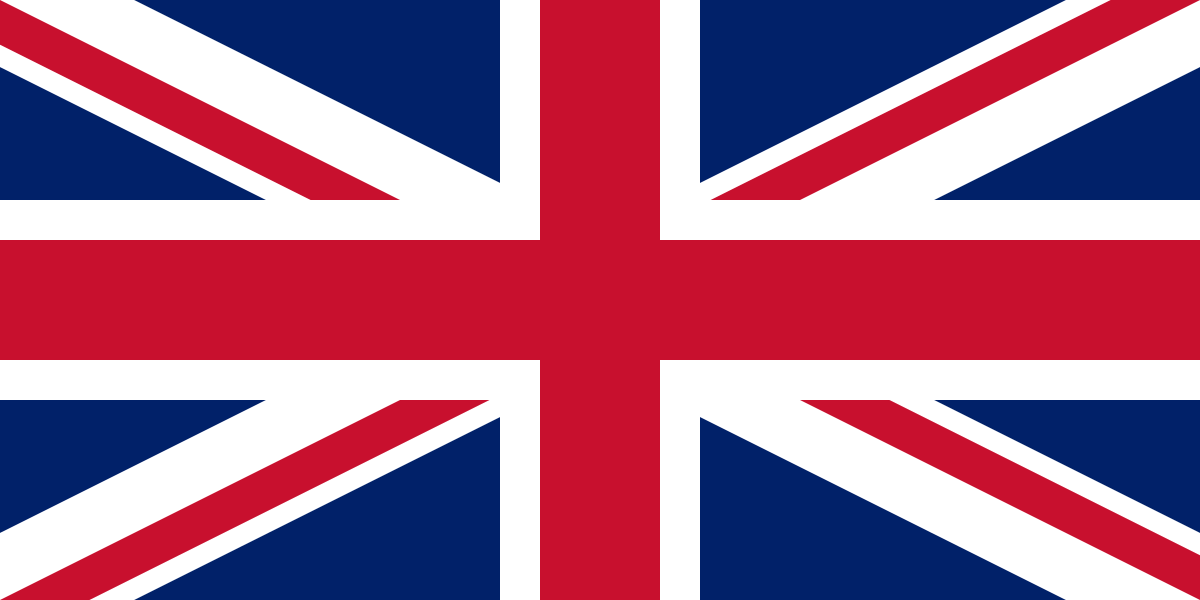

In [26]:
import requests
from IPython.display import SVG, Image # Import both just in case, but we'll use SVG for this link

image_url = "https://upload.wikimedia.org/wikipedia/en/a/ae/Flag_of_the_United_Kingdom.svg"

response = requests.get(image_url, verify=False)
display(SVG(data=response.content))